# Psychedelic experience data

Correlations among experience data and microstate statistics

In [1]:
%matplotlib inline

import os
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from IPython.display import display
from pingouin.multicomp import multicomp
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA

from src.helpers import DATA_ROOT, PLOTS_ROOT, RESULTS_ROOT, make_dirs

plt.rcParams["figure.figsize"] = (20, 9)
plt.style.use("default_light")
plt.rcParams["legend.frameon"] = False

MS_STATS_ROOT = os.path.join(RESULTS_ROOT, "microstates")
WORKING_DIR = os.path.join(RESULTS_ROOT, "experience")
if not os.path.exists(WORKING_DIR):
    make_dirs(WORKING_DIR)
PLOTTING_DIR = os.path.join(PLOTS_ROOT, "experience")
if not os.path.exists(PLOTTING_DIR):
    make_dirs(PLOTTING_DIR)

# if True, will save all statistical tests as csv and all plots as eps
SAVE_RESULTS = False
PLOT_EXT = ".png"
# which correction for multiple comparisons should be used
MULTI_CORRECTION = "fdr_by"
PVAL_STARS = {0.01: "***", 0.05: "**", 0.1: "*"}

In [2]:
experience = pd.read_csv(
    os.path.join(DATA_ROOT, "experience_data", "experience_processed.csv")
)
experience = experience.rename(columns={"group": "condition"})

persisting_effs = pd.read_csv(
    os.path.join(DATA_ROOT, "experience_data", "persisting_effects_scale_processed.csv")
)
persisting_effs = persisting_effs.rename(columns={"group": "condition"})

ms_stats = pd.read_csv(os.path.join(MS_STATS_ROOT, "ms_stats.csv"), index_col=[0])
# divide session into PLA/PSI and time for plotting purposes
ms_stats[["condition", "time"]] = ms_stats["session"].str.split("-", expand=True)
# divide to filters
ms_stats_220 = ms_stats[ms_stats["ms_opts"] == "(2.0, 20.0, 4)"]
ms_stats_220 = ms_stats_220.sort_values(by=["condition", "time"])
ms_stats_140 = ms_stats[ms_stats["ms_opts"] == "(1.0, 40.0, 3)"]
ms_stats_140 = ms_stats_140.sort_values(by=["condition", "time"])

In [3]:
def pd_pca(df, n_comps, col_name=None):
    if col_name is None:
        col_name = ""
    else:
        col_name += "_"
    pca = PCA(n_components=n_comps)
    pcs = pca.fit_transform(df.values)
    return pd.DataFrame(
        pcs,
        index=df.index,
        columns=[
            f"{col_name}PC{i+1}_{pca.explained_variance_ratio_[i]:.1%}"
            for i in range(n_comps)
        ],
    )


def plot_corr(
    df,
    method="pearson",
    title="",
    mask_upper=True,
    mask_pval=True,
    fname=None,
    lines=None,
):
    plt.figure(figsize=(16, 14))
    corr = df.corr(method=method)
    lines = lines or []

    def pval_func(x, y):
        if method == "pearson":
            return pearsonr(x, y)[1]
        elif method == "spearman":
            return spearmanr(x, y)[1]

    pval = df.corr(method=pval_func)
    mask_up = (
        np.triu(np.ones_like(corr, dtype=bool))
        if mask_upper
        else np.zeros_like(corr, dtype=bool)
    )
    mask_pval = pval > 0.05 if mask_pval else np.zeros_like(corr, dtype=bool)
    mask = np.logical_or(mask_up, mask_pval)
    sns.heatmap(
        corr,
        annot=df.rcorr(
            method=method,
            upper="pval",
            decimals=2,
            padjust=MULTI_CORRECTION,
            stars=True,
            pval_stars={0.01: "***", 0.05: "**", 0.1: "*"},
        ),
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        mask=mask,
        fmt="",
        cbar_kws={"shrink": 0.5},
    )
    xlims = plt.gca().get_xlim()
    ylims = plt.gca().get_ylim()
    plt.plot(
        [xlims[0], xlims[1]],
        [ylims[1], ylims[0]],
        "--",
        color=plt.rcParams["text.color"],
        linewidth=1.0,
    )
    plt.hlines(
        lines, *plt.gca().get_xlim(), color=plt.rcParams["text.color"], linewidth=1.0
    )
    plt.vlines(
        lines, *plt.gca().get_ylim(), color=plt.rcParams["text.color"], linewidth=1.0
    )
    plt.title(title)
    if SAVE_RESULTS:
        plt.savefig(
            os.path.join(PLOTTING_DIR, f"{fname}_{method}_correlation{PLOT_EXT}"),
            bbox_inches="tight",
            transparent=True,
        )
        p = pval.applymap(replace_pval)
        corr = corr.round(5).astype(str) + p
        corr.to_csv(os.path.join(WORKING_DIR, f"{fname}_{method}_correlation.csv"))


def replace_pval(x, pval_stars=PVAL_STARS):
    for key, value in pval_stars.items():
        if x < key:
            return value
    return ""

## Correlations within experience data

### Only psilocybin condition

/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


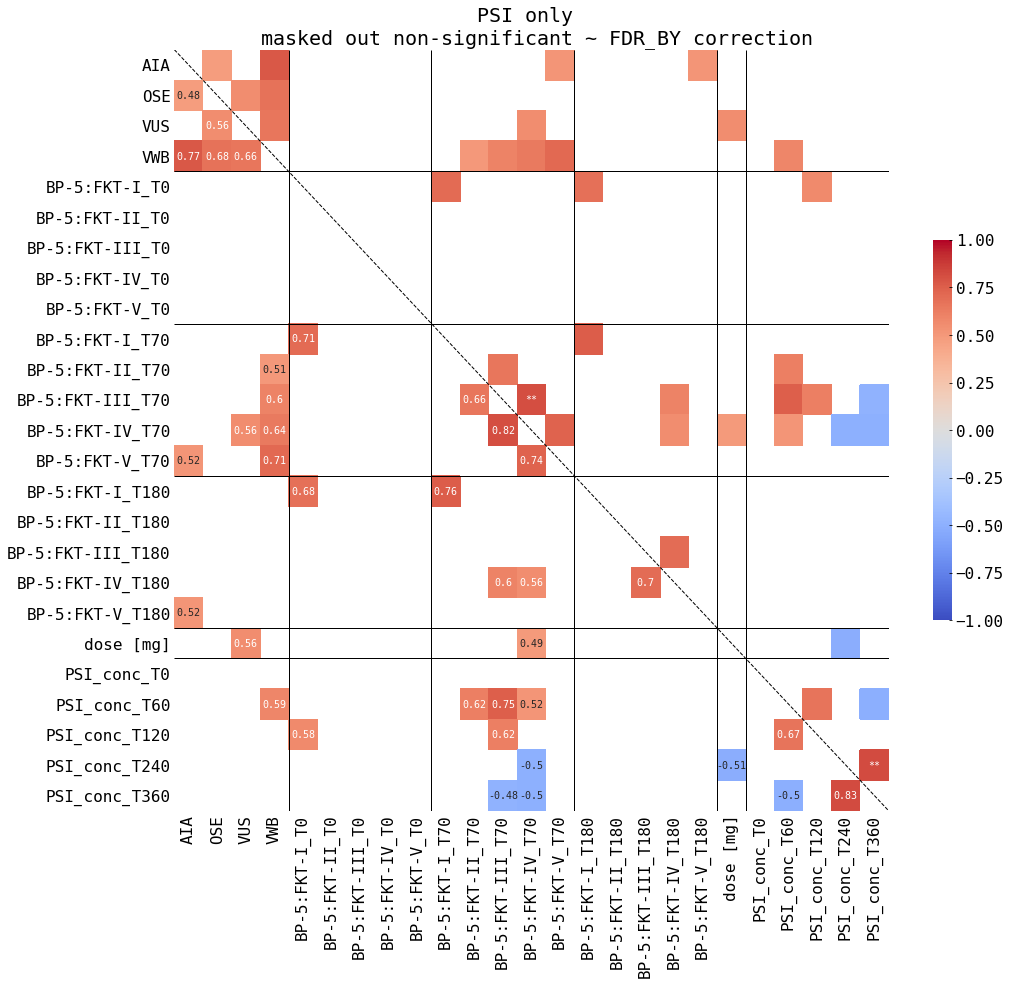

In [4]:
# only pval <= 0.05 unmasked
plot_corr(
    experience[experience["condition"] == "PSI"].drop("subject", axis=1),
    title=f"PSI only \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction",
    mask_upper=False,
    mask_pval=True,
    lines=[4, 9, 14, 19, 20],
    method="spearman",
    fname="experience_PSIonly",
)

### Both psilocybin and placebo conditions

/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


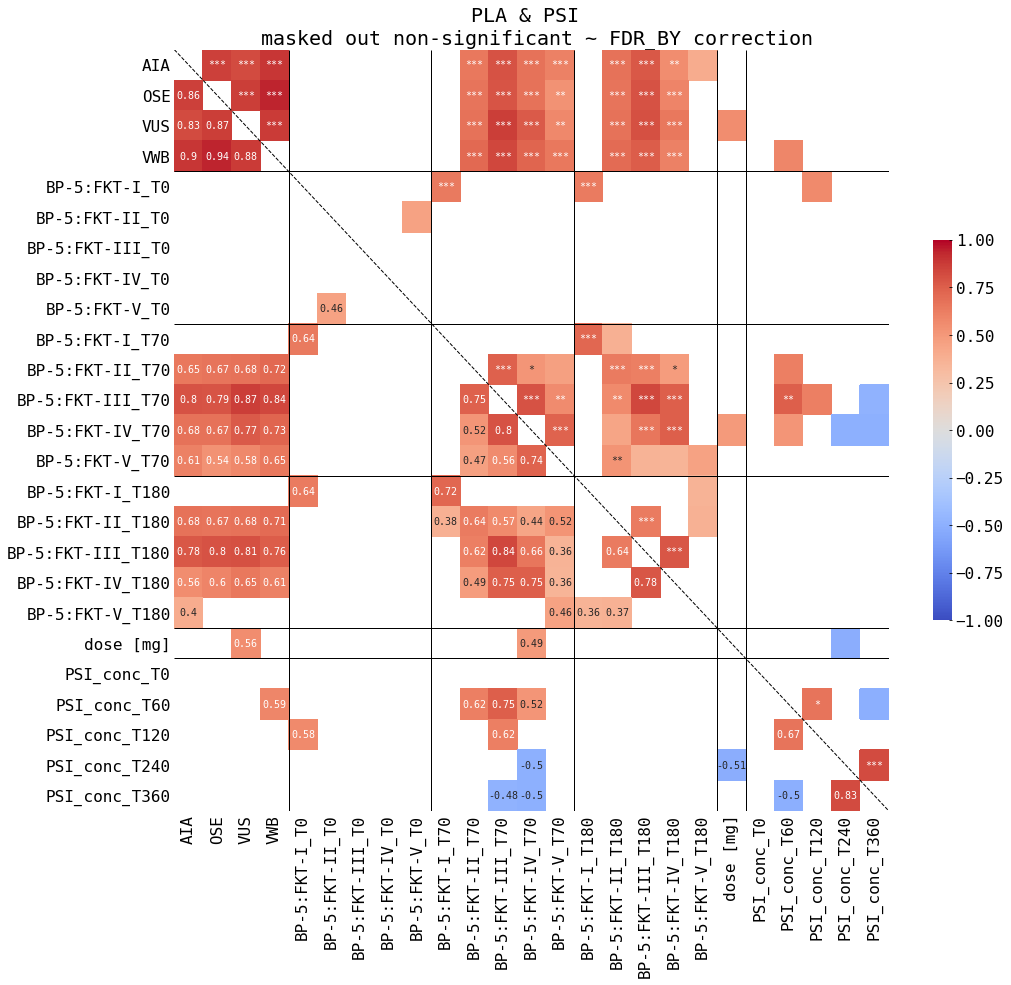

In [5]:
# only pval <= 0.05 unmasked
plot_corr(
    experience.drop("subject", axis=1),
    title=f"PLA & PSI \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction",
    mask_upper=False,
    mask_pval=True,
    lines=[4, 9, 14, 19, 20],
    method="spearman",
    fname="experience_PLAandPSI",
)

## Correlations with ASC questionnaire

In [6]:
ASC = ["AIA", "OSE", "VUS", "VWB"]

experience_asc = experience[["subject", "condition"] + ASC]
# match subjects
experience_asc = experience_asc.loc[experience_asc["subject"].isin(ms_stats["subject"])]

In [7]:
grand = pd.DataFrame([])
grand_pvals = pd.DataFrame([])
for time in np.unique(ms_stats_140["time"]):
    for ms in np.unique(ms_stats_140["microstate"]):
        for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
            asc_corrs = pd.concat(
                [
                    ms_stats_140[
                        (ms_stats_140["condition"] == "PSI")
                        & (ms_stats_140["microstate"] == ms)
                        & (ms_stats_140["time"] == time)
                    ]
                    .drop(ms_stats_140.filter(regex="transition"), axis=1)
                    .set_index("subject")
                    .corrwith(
                        experience_asc[experience_asc["condition"] == "PSI"].set_index(
                            "subject"
                        )[asc],
                        method=method,
                    )
                    for asc in ASC
                ],
                axis=1,
            )
            asc_corrs.columns = ASC
            asc_corrs["microstate"] = ms
            asc_corrs["time"] = time
            asc_corrs = asc_corrs.dropna(axis=1)
            asc_corrs.index = asc_corrs.index.rename("stat")
            asc_corrs = asc_corrs.set_index(["time", "microstate", asc_corrs.index])
            if method == "spearman":
                grand = pd.concat([grand, asc_corrs], axis=0)
            else:
                grand_pvals = pd.concat([grand_pvals, asc_corrs], axis=0)

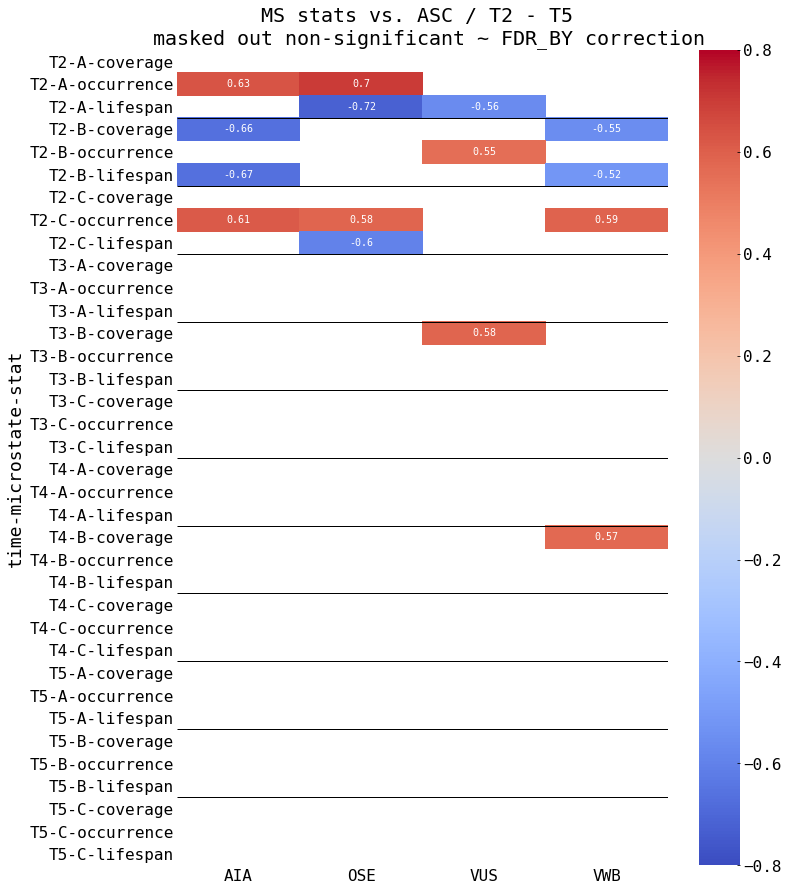

In [8]:
plot_times = ["T2", "T3", "T4", "T5"]

plt.figure(figsize=(11, 15))
plot_df = grand[grand.index.get_level_values("time").isin(plot_times)]
_, bonf_corrd = multicomp(
    grand_pvals[grand_pvals.index.get_level_values("time").isin(plot_times)].values,
    alpha=0.05,
    method=MULTI_CORRECTION,
)
bonf_corrd = pd.DataFrame(
    bonf_corrd, columns=plot_df.columns, index=plot_df.index
).applymap(replace_pval)
sns.heatmap(
    plot_df,
    cmap="coolwarm",
    annot=plot_df.round(2).astype(str) + bonf_corrd,
    vmin=-0.8,
    vmax=0.8,
    fmt="",
    mask=grand_pvals[grand.index.get_level_values("time").isin(plot_times)] > 0.05,
)
plt.hlines(
    np.arange(3, grand.shape[0], 3).tolist(),
    *plt.gca().get_xlim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.vlines([], *plt.gca().get_ylim(), color=plt.rcParams["text.color"], linewidth=1.0)
plt.title(
    f"MS stats vs. ASC / T2 - T5 \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction"
)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(
            PLOTTING_DIR, f"MSstats_w_ASC_T2-T5_1-40filt_spearman_correlation{PLOT_EXT}"
        ),
        bbox_inches="tight",
        transparent=True,
    )
    p = grand_pvals.applymap(
        lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x <= t])
    )
    corr = grand.round(5).astype(str) + p
    corr.to_csv(
        os.path.join(WORKING_DIR, "MSstats_w_ASC_1-40filt_spearman_correlation.csv")
    )

## Correlations with BPRS questionnaire

In [9]:
BP = list(experience.filter(like="BP").columns)

experience_bprs = experience[["subject", "condition"] + BP]
# match subjects
experience_bprs = experience_bprs.loc[
    experience_bprs["subject"].isin(ms_stats["subject"])
]

In [10]:
grand = pd.DataFrame([])
grand_pvals = pd.DataFrame([])
for time in np.unique(ms_stats_140["time"]):
    for ms in np.unique(ms_stats_140["microstate"]):
        for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
            bprs_corrs = pd.concat(
                [
                    ms_stats_140[
                        (ms_stats_140["condition"] == "PSI")
                        & (ms_stats_140["microstate"] == ms)
                        & (ms_stats_140["time"] == time)
                    ]
                    .drop(ms_stats_140.filter(regex="transition"), axis=1)
                    .set_index("subject")
                    .corrwith(
                        experience_bprs[
                            experience_bprs["condition"] == "PSI"
                        ].set_index("subject")[bprs],
                        method=method,
                    )
                    for bprs in BP
                ],
                axis=1,
            )
            bprs_corrs.columns = BP
            bprs_corrs["microstate"] = ms
            bprs_corrs["time"] = time
            bprs_corrs = bprs_corrs.dropna(axis=1)
            bprs_corrs.index = bprs_corrs.index.rename("stat")
            bprs_corrs = bprs_corrs.set_index(["time", "microstate", bprs_corrs.index])
            if method == "spearman":
                grand = pd.concat([grand, bprs_corrs], axis=0)
            else:
                grand_pvals = pd.concat([grand_pvals, bprs_corrs], axis=0)

/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/nikola/.virtu

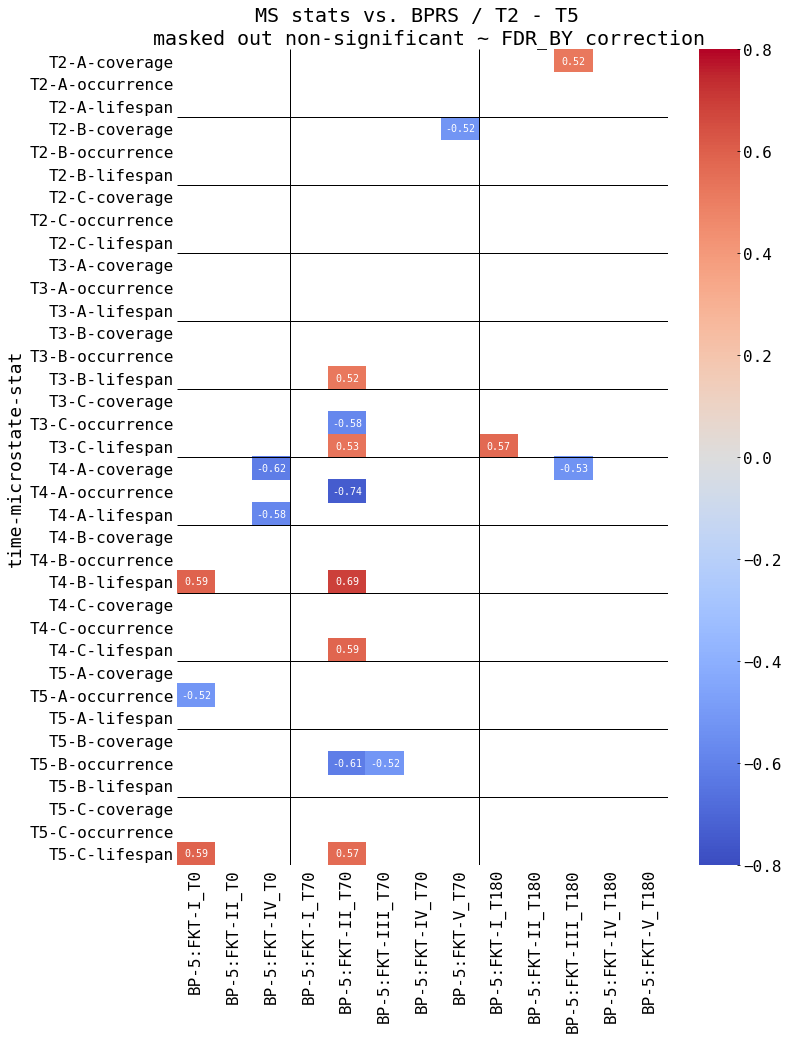

In [11]:
plot_times = ["T2", "T3", "T4", "T5"]

plt.figure(figsize=(11, 15))
plot_df = grand[grand.index.get_level_values("time").isin(plot_times)]
_, bonf_corrd = multicomp(
    grand_pvals[grand_pvals.index.get_level_values("time").isin(plot_times)].values,
    alpha=0.05,
    method=MULTI_CORRECTION,
)
bonf_corrd = pd.DataFrame(
    bonf_corrd, columns=plot_df.columns, index=plot_df.index
).applymap(replace_pval)

sns.heatmap(
    plot_df,
    cmap="coolwarm",
    annot=plot_df.round(2).astype(str) + bonf_corrd,
    vmin=-0.8,
    vmax=0.8,
    fmt="",
    mask=grand_pvals[grand.index.get_level_values("time").isin(plot_times)] > 0.05,
)
plt.hlines(
    np.arange(3, grand.shape[0], 3).tolist(),
    *plt.gca().get_xlim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.vlines(
    [3, 8], *plt.gca().get_ylim(), color=plt.rcParams["text.color"], linewidth=1.0
)
plt.title(
    f"MS stats vs. BPRS / T2 - T5 \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction"
)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(
            PLOTTING_DIR,
            f"MSstats_w_BPRS_T2-T5_1-40filt_spearman_correlation{PLOT_EXT}",
        ),
        bbox_inches="tight",
        transparent=True,
    )
    p = grand_pvals.applymap(
        lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x <= t])
    )
    corr = grand.round(5).astype(str) + p
    corr.to_csv(
        os.path.join(WORKING_DIR, "MSstats_w_BPRS_1-40filt_spearman_correlation.csv")
    )

## Correlations with dosage

In [12]:
CONC = list(experience.filter(like="conc").columns) + ["dose [mg]"]

experience_conc = experience[["subject", "condition"] + CONC]
# match subjects
experience_conc = experience_conc.loc[
    experience_conc["subject"].isin(ms_stats["subject"])
]

In [13]:
grand = pd.DataFrame([])
grand_pvals = pd.DataFrame([])
for time in np.unique(ms_stats_140["time"]):
    for ms in np.unique(ms_stats_140["microstate"]):
        for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
            conc_corrs = pd.concat(
                [
                    ms_stats_140[
                        (ms_stats_140["condition"] == "PSI")
                        & (ms_stats_140["microstate"] == ms)
                        & (ms_stats_140["time"] == time)
                    ]
                    .drop(ms_stats_140.filter(regex="transition"), axis=1)
                    .set_index("subject")
                    .corrwith(
                        experience_conc[
                            experience_conc["condition"] == "PSI"
                        ].set_index("subject")[conc],
                        method=method,
                    )
                    for conc in CONC
                ],
                axis=1,
            )
            conc_corrs.columns = CONC
            conc_corrs["microstate"] = ms
            conc_corrs["time"] = time
            conc_corrs = conc_corrs.dropna(axis=1)
            conc_corrs.index = conc_corrs.index.rename("stat")
            conc_corrs = conc_corrs.set_index(["time", "microstate", conc_corrs.index])
            if method == "spearman":
                grand = pd.concat([grand, conc_corrs], axis=0)
            else:
                grand_pvals = pd.concat([grand_pvals, conc_corrs], axis=0)

/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/nikola/.virtu

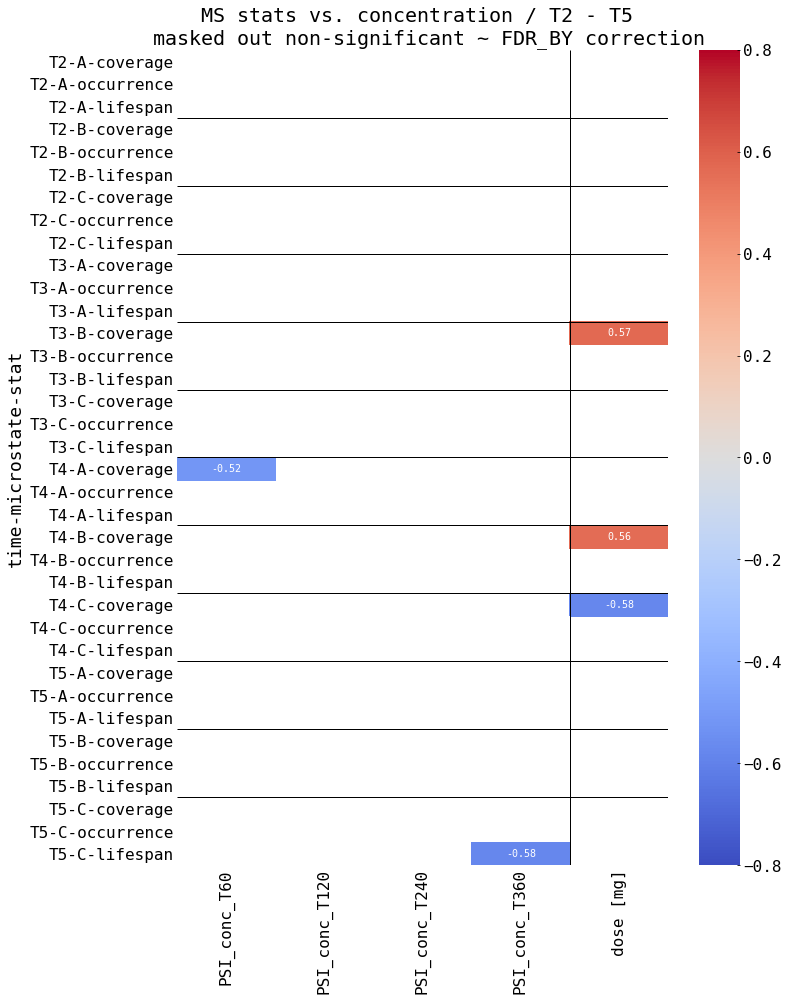

In [14]:
plot_times = ["T2", "T3", "T4", "T5"]

plt.figure(figsize=(11, 15))
plot_df = grand[grand.index.get_level_values("time").isin(plot_times)]
_, bonf_corrd = multicomp(
    grand_pvals[grand_pvals.index.get_level_values("time").isin(plot_times)].values,
    alpha=0.05,
    method=MULTI_CORRECTION,
)
bonf_corrd = pd.DataFrame(
    bonf_corrd, columns=plot_df.columns, index=plot_df.index
).applymap(replace_pval)

sns.heatmap(
    plot_df,
    cmap="coolwarm",
    annot=plot_df.round(2).astype(str) + bonf_corrd,
    vmin=-0.8,
    vmax=0.8,
    fmt="",
    mask=grand_pvals[grand.index.get_level_values("time").isin(plot_times)] > 0.05,
)
plt.hlines(
    np.arange(3, grand.shape[0], 3).tolist(),
    *plt.gca().get_xlim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.vlines([4], *plt.gca().get_ylim(), color=plt.rcParams["text.color"], linewidth=1.0)
plt.title(
    f"MS stats vs. concentration / T2 - T5 \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction"
)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(
            PLOTTING_DIR,
            f"MSstats_w_conc_T2-T5_1-40filt_spearman_correlation{PLOT_EXT}",
        ),
        bbox_inches="tight",
        transparent=True,
    )
    p = grand_pvals.applymap(
        lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x <= t])
    )
    corr = grand.round(5).astype(str) + p
    corr.to_csv(
        os.path.join(WORKING_DIR, "MSstats_w_conc_1-40filt_spearman_correlation.csv")
    )

## Correlations with persistent effects

In [15]:
# match subjects
persisting = persisting_effs.drop("order", axis=1).loc[
    persisting_effs["subject"].isin(ms_stats["subject"])
]
EFFECTS = list(persisting.columns[2:])

In [16]:
grand = pd.DataFrame([])
grand_pvals = pd.DataFrame([])
for time in np.unique(ms_stats_140["time"]):
    for ms in np.unique(ms_stats_140["microstate"]):
        for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
            pers_corrs = pd.concat(
                [
                    ms_stats_140[
                        (ms_stats_140["condition"] == "PSI")
                        & (ms_stats_140["microstate"] == ms)
                        & (ms_stats_140["time"] == time)
                    ]
                    .drop(ms_stats_140.filter(regex="transition"), axis=1)
                    .set_index("subject")
                    .corrwith(
                        persisting[persisting["condition"] == "PSI"].set_index(
                            "subject"
                        )[eff],
                        method=method,
                    )
                    for eff in EFFECTS
                ],
                axis=1,
            )
            pers_corrs.columns = EFFECTS
            pers_corrs["microstate"] = ms
            pers_corrs["time"] = time
            pers_corrs = pers_corrs.dropna(axis=1)
            pers_corrs.index = pers_corrs.index.rename("stat")
            pers_corrs = pers_corrs.set_index(["time", "microstate", pers_corrs.index])
            if method == "spearman":
                grand = pd.concat([grand, pers_corrs], axis=0)
            else:
                grand_pvals = pd.concat([grand_pvals, pers_corrs], axis=0)

/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/nikola/.virtu

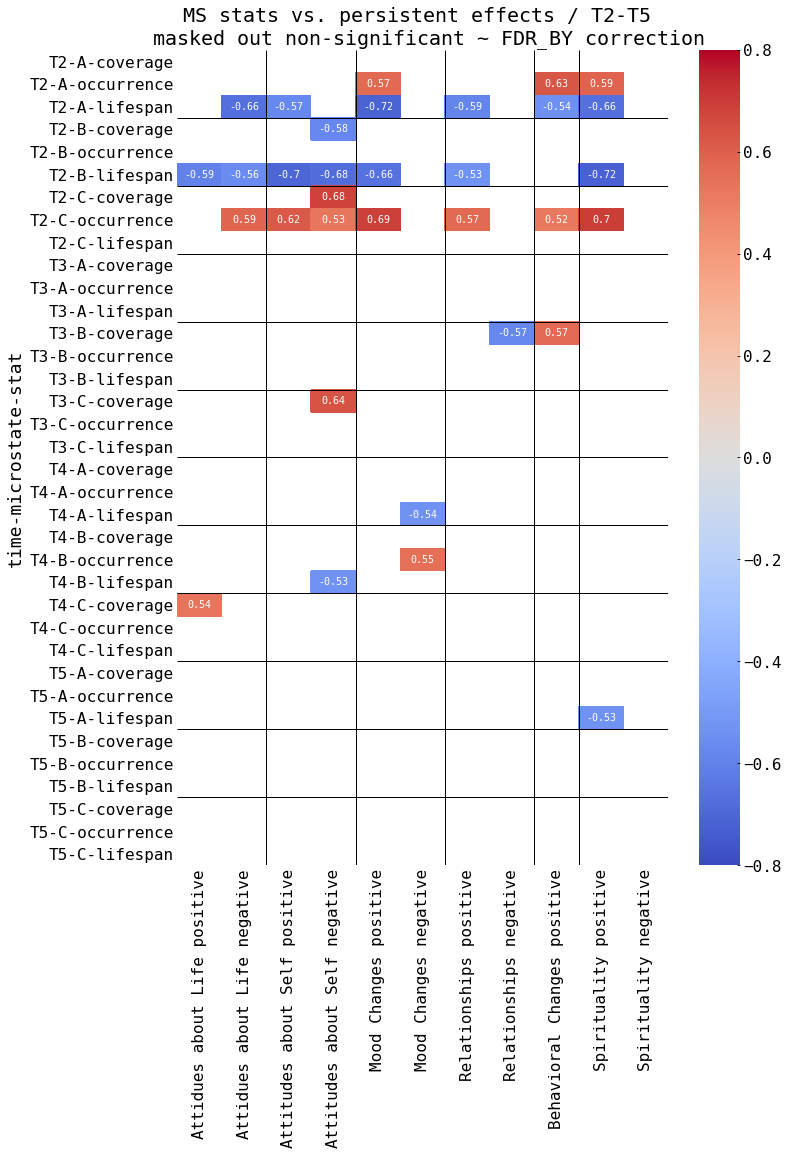

In [17]:
plot_times = ["T2", "T3", "T4", "T5"]

plt.figure(figsize=(11, 15))
plot_df = grand[grand.index.get_level_values("time").isin(plot_times)]
_, bonf_corrd = multicomp(
    grand_pvals[grand_pvals.index.get_level_values("time").isin(plot_times)].values,
    alpha=0.05,
    method=MULTI_CORRECTION,
)
bonf_corrd = pd.DataFrame(
    bonf_corrd, columns=plot_df.columns, index=plot_df.index
).applymap(replace_pval)

sns.heatmap(
    plot_df,
    cmap="coolwarm",
    annot=plot_df.round(2).astype(str) + bonf_corrd,
    vmin=-0.8,
    vmax=0.8,
    fmt="",
    mask=grand_pvals[grand.index.get_level_values("time").isin(plot_times)] > 0.05,
)
plt.hlines(
    np.arange(3, grand.shape[0], 3).tolist(),
    *plt.gca().get_xlim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.vlines(
    [2, 4, 6, 8, 9],
    *plt.gca().get_ylim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.title(
    f"MS stats vs. persistent effects / T2-T5 \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction"
)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(
            PLOTTING_DIR,
            f"MSstats_w_persistent_effects_T2-T5_1-40filt_spearman_correlation{PLOT_EXT}",
        ),
        bbox_inches="tight",
        transparent=True,
    )
    p = grand_pvals.applymap(
        lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x <= t])
    )
    corr = grand.round(5).astype(str) + p
    corr.to_csv(
        os.path.join(
            WORKING_DIR,
            "MSstats_w_persistent_effects_1-40filt_spearman_correlation.csv",
        )
    )

In [18]:
# group data in experience data
experience_grp = experience[experience["condition"] == "PSI"].loc[
    experience["subject"].isin(ms_stats_140["subject"])
]
experience_grp = experience_grp.drop(["order", "usage time"], axis=1).set_index(
    ["subject", "condition"]
)
groupings = {
    "ASC": ASC,
    "BPRS_T70": list(experience_grp.filter(like="T70").columns),
    "BPRS_T180": list(experience_grp.filter(like="T180").columns),
}

for key, val in groupings.items():
    experience_grp = pd.concat(
        [experience_grp, pd_pca(experience_grp[val], 1, key)], axis=1
    ).drop(val, axis=1)
experience_grp = experience_grp.drop(
    list(experience_grp.filter(like="T0").columns), axis=1
)
experience_grp.index = experience_grp.index.droplevel("condition")

In [19]:
persisting_effs_grp = persisting_effs[persisting_effs["condition"] == "PSI"].loc[
    persisting_effs["subject"].isin(ms_stats_140["subject"])
]
persisting_effs_grp = persisting_effs_grp.drop(
    ["order", "condition"] + list(persisting_effs_grp.filter(like="negative").columns),
    axis=1,
).set_index("subject")

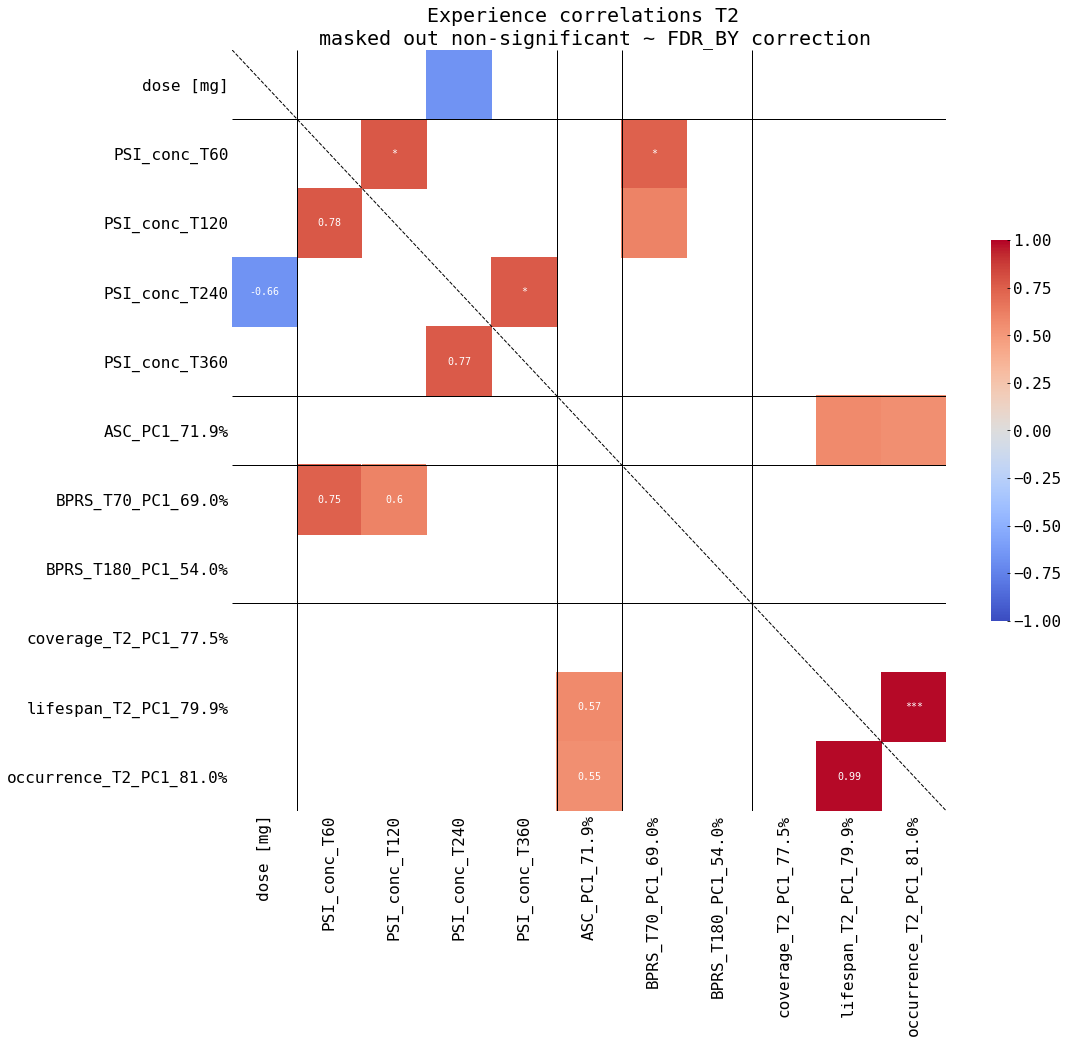

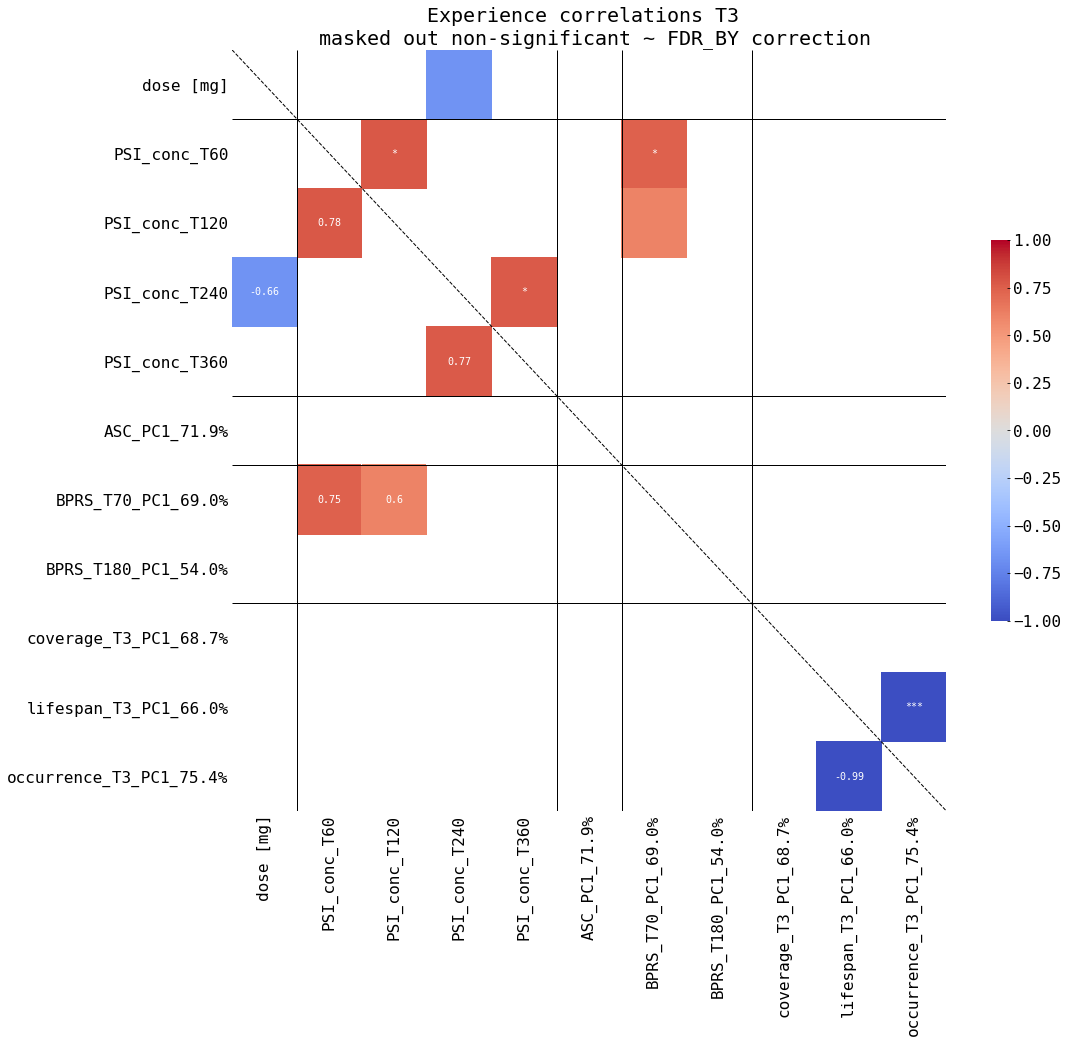

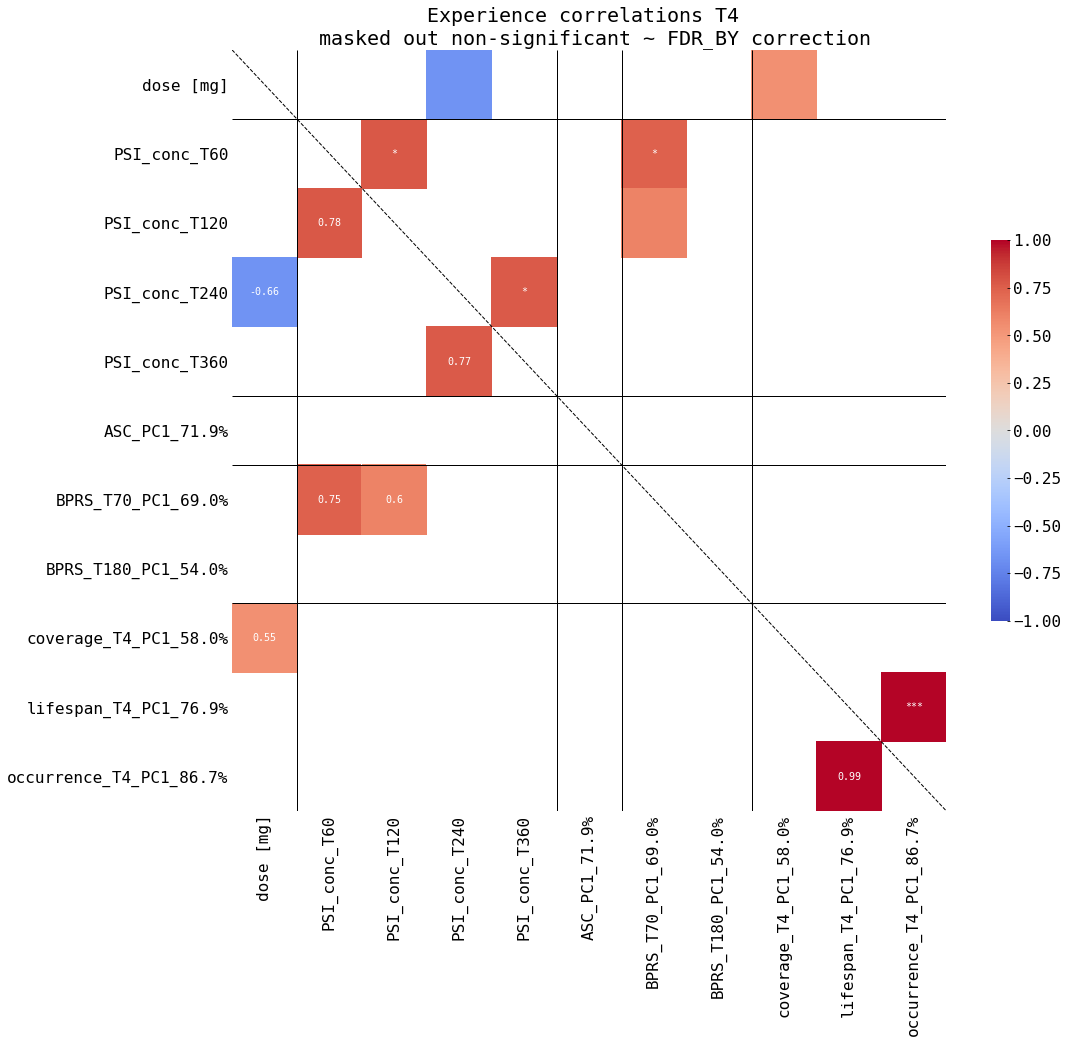

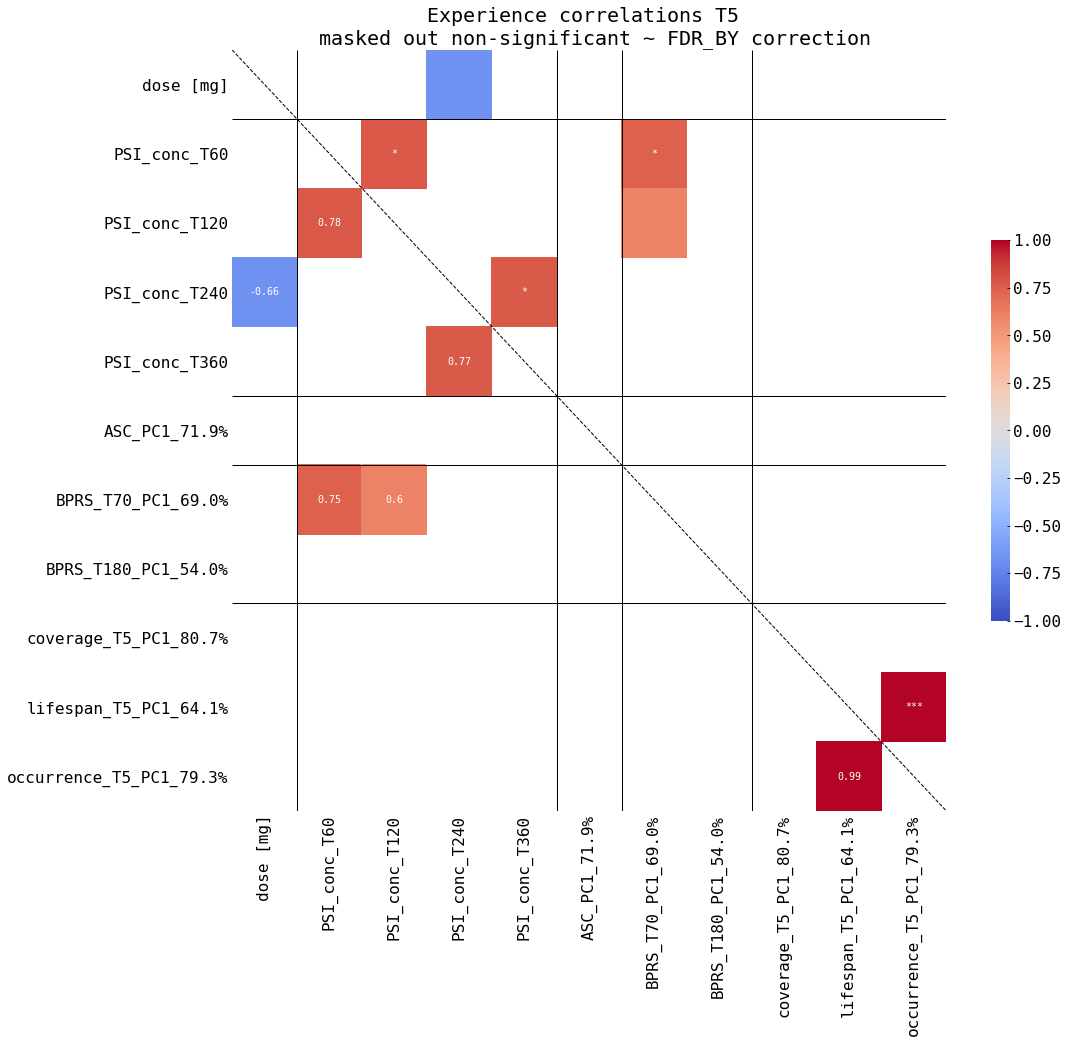

In [20]:
ms_stats_140_grp = (
    ms_stats_140[ms_stats_140["condition"] == "PSI"]
    .drop(["session", "ms_opts"], axis=1)
    .set_index(["subject", "condition", "time"])
)
groupings = ["coverage", "lifespan", "occurrence"]

for time in ["T2", "T3", "T4", "T5"]:
    ms_stats_grp = pd.DataFrame()
    for grp in groupings:
        pca_mat = pd_pca(
            ms_stats_140_grp[ms_stats_140_grp.index.get_level_values("time") == time]
            .reset_index()
            .pivot(index="subject", columns="microstate", values=grp),
            1,
            f"{grp}_{time}",
        )
        ms_stats_grp = pd.concat([ms_stats_grp, pca_mat], axis=1)

    grp_corrs = pd.concat([experience_grp, ms_stats_grp], axis=1)
    plot_corr(
        grp_corrs,
        method="spearman",
        mask_upper=False,
        mask_pval=True,
        lines=[1, 5, 6, 8],
        title=f"Experience correlations {time} \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction",
        fname=f"experience_agg_{time}",
    )

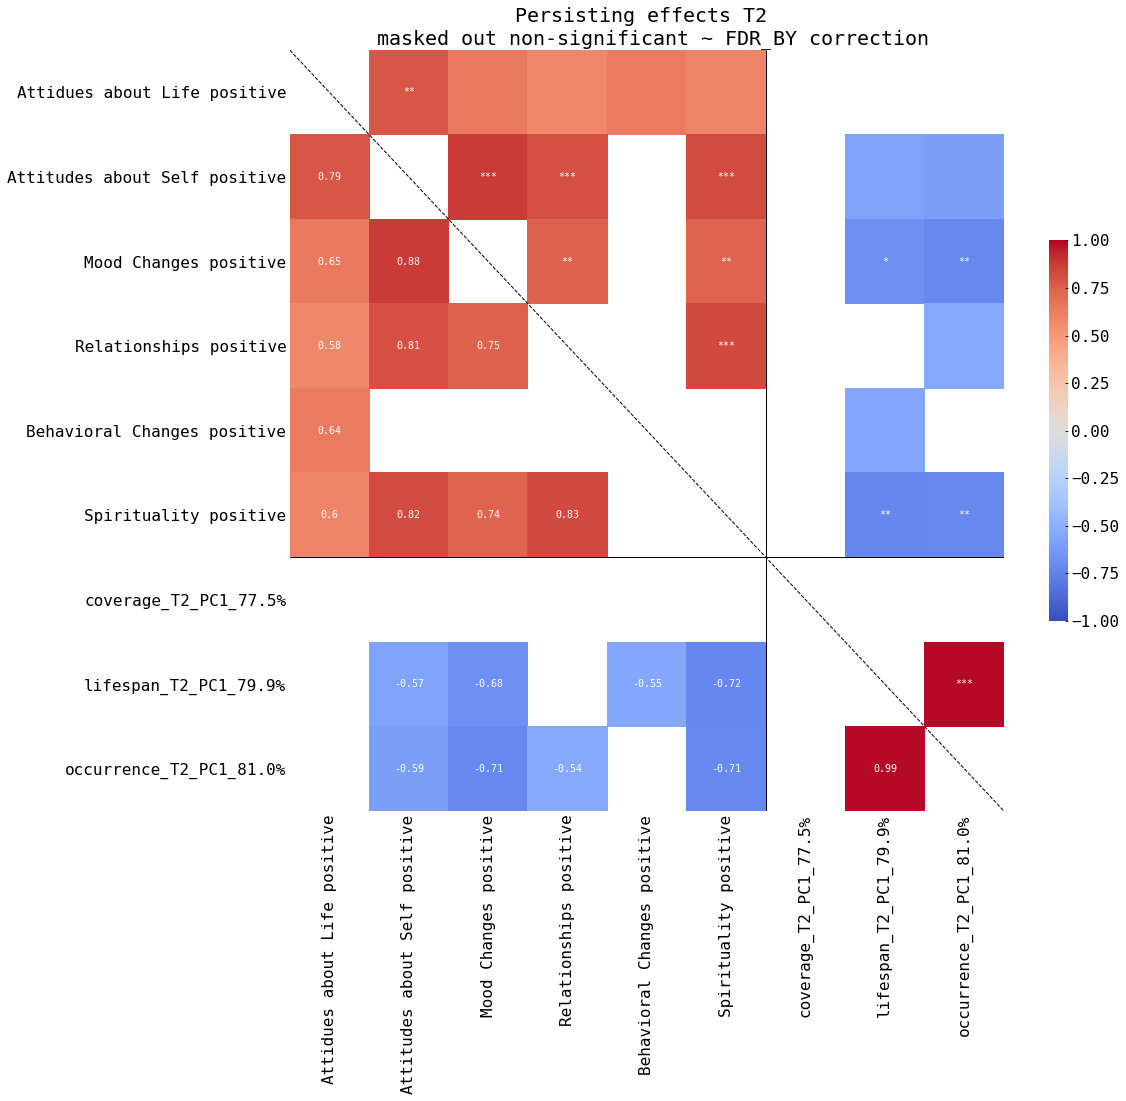

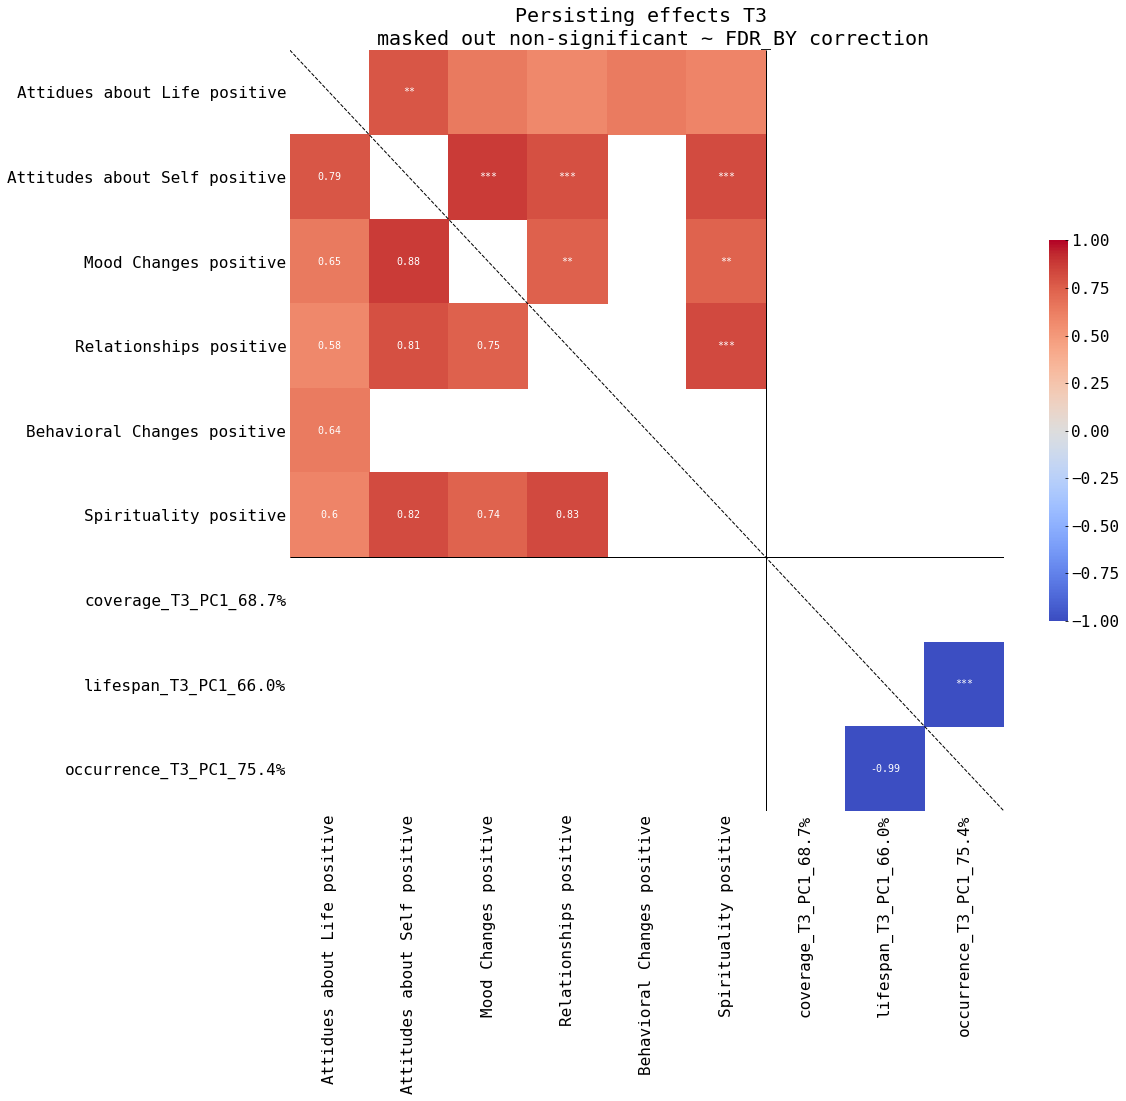

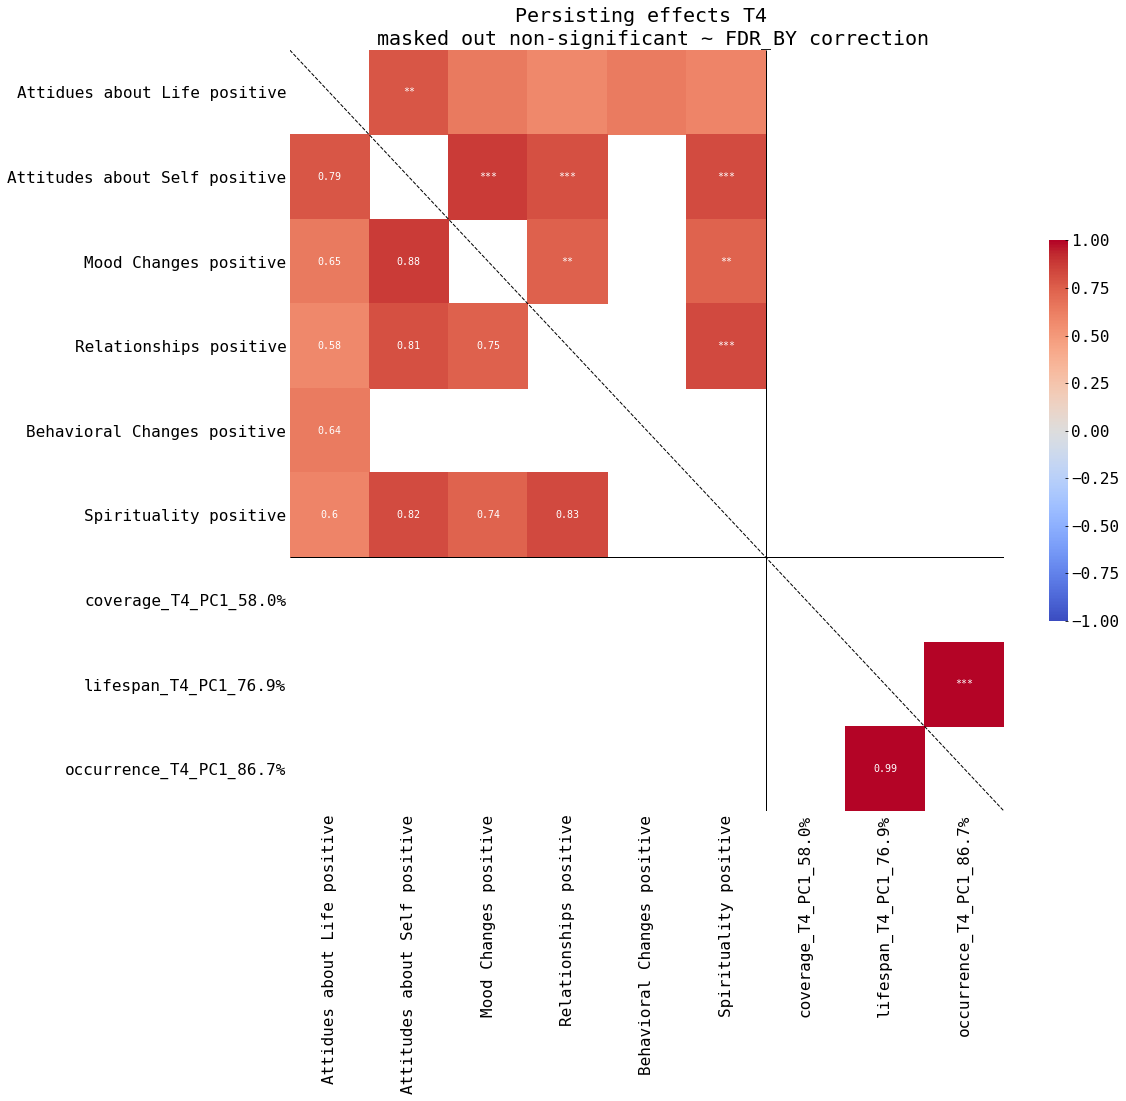

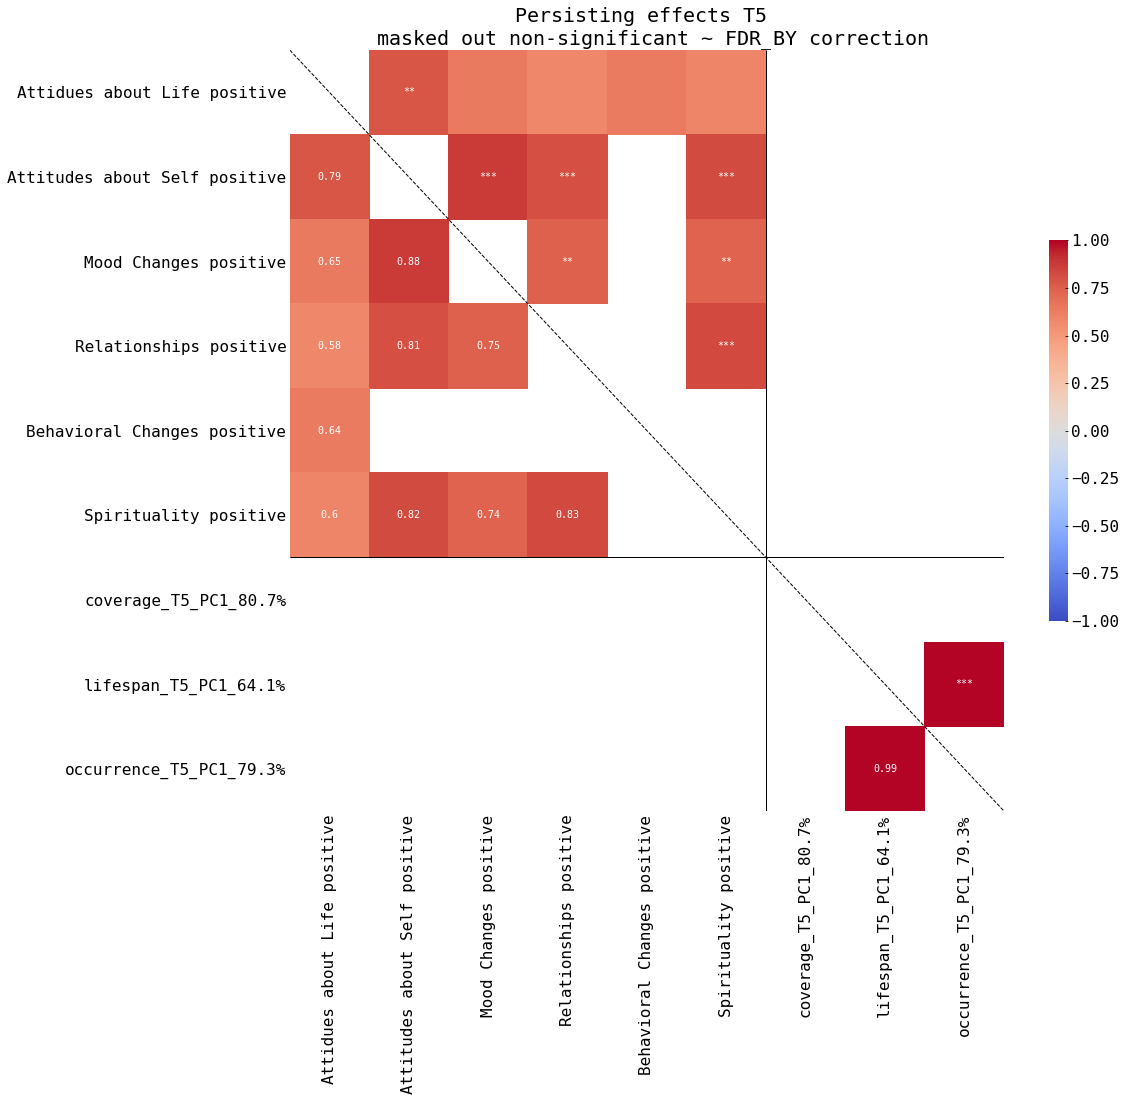

In [21]:
ms_stats_140_grp = (
    ms_stats_140[ms_stats_140["condition"] == "PSI"]
    .drop(["session", "ms_opts"], axis=1)
    .set_index(["subject", "condition", "time"])
)
groupings = ["coverage", "lifespan", "occurrence"]

for time in ["T2", "T3", "T4", "T5"]:
    ms_stats_grp = pd.DataFrame()
    for grp in groupings:
        pca_mat = pd_pca(
            ms_stats_140_grp[ms_stats_140_grp.index.get_level_values("time") == time]
            .reset_index()
            .pivot(index="subject", columns="microstate", values=grp),
            1,
            f"{grp}_{time}",
        )
        ms_stats_grp = pd.concat([ms_stats_grp, pca_mat], axis=1)

    grp_corrs = pd.concat([persisting_effs_grp, ms_stats_grp], axis=1)
    plot_corr(
        grp_corrs,
        method="spearman",
        mask_upper=False,
        mask_pval=True,
        lines=[6],
        title=f"Persisting effects {time} \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction",
        fname=f"persisting_effs_agg_{time}",
    )

In [22]:
experience_asc_conc = pd.concat(
    [experience_asc, experience_conc["PSI_conc_T60"]], axis=1
)
experience_asc_conc = experience_asc_conc[
    experience_asc_conc["condition"] == "PSI"
].drop("condition", axis=1)

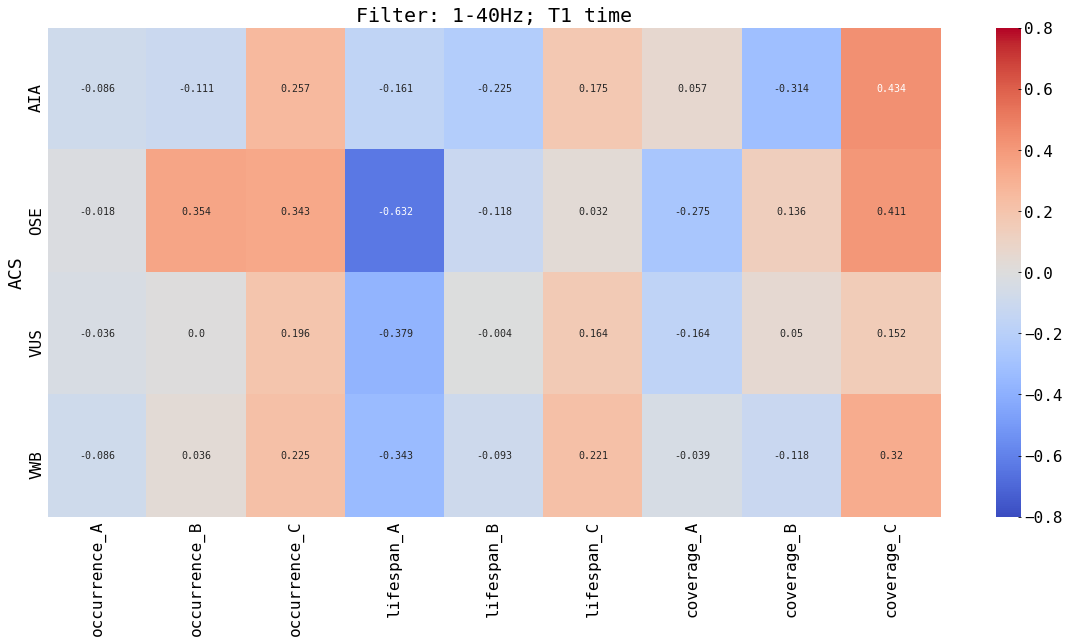

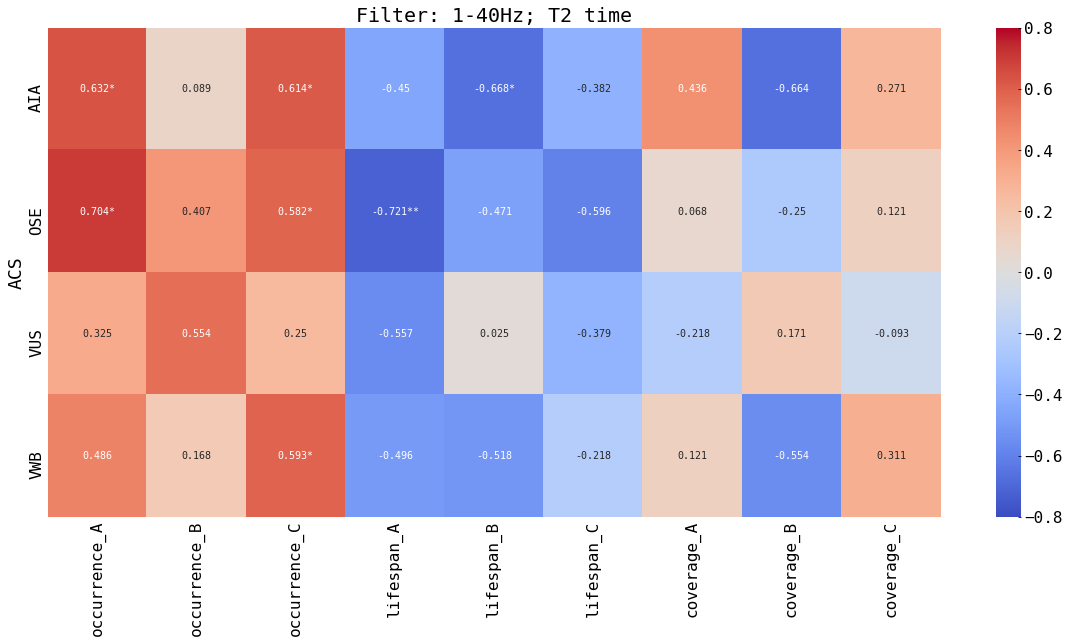

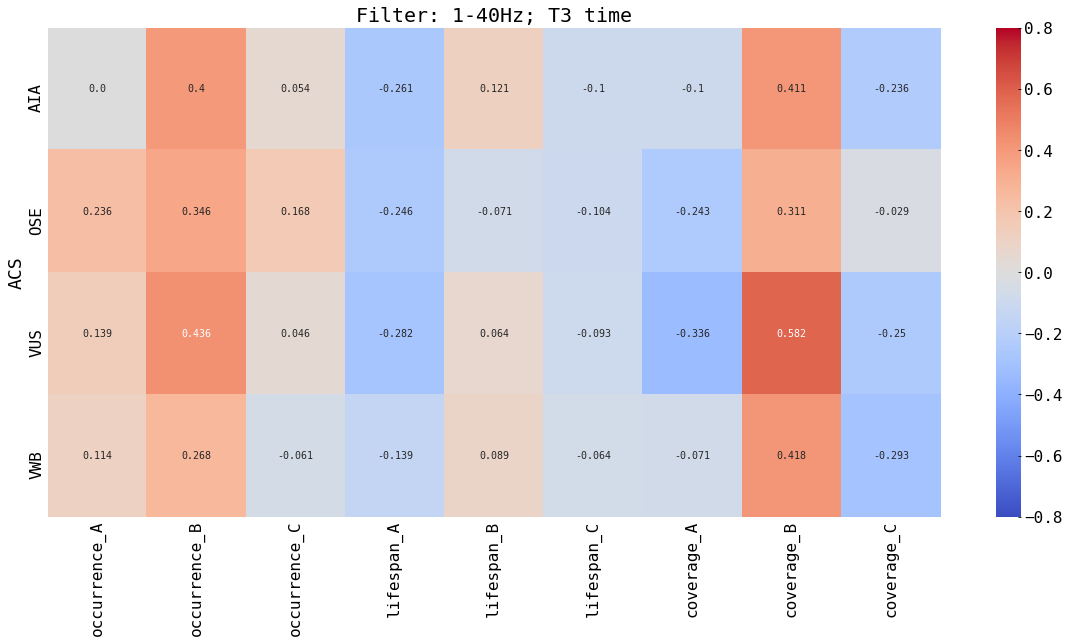

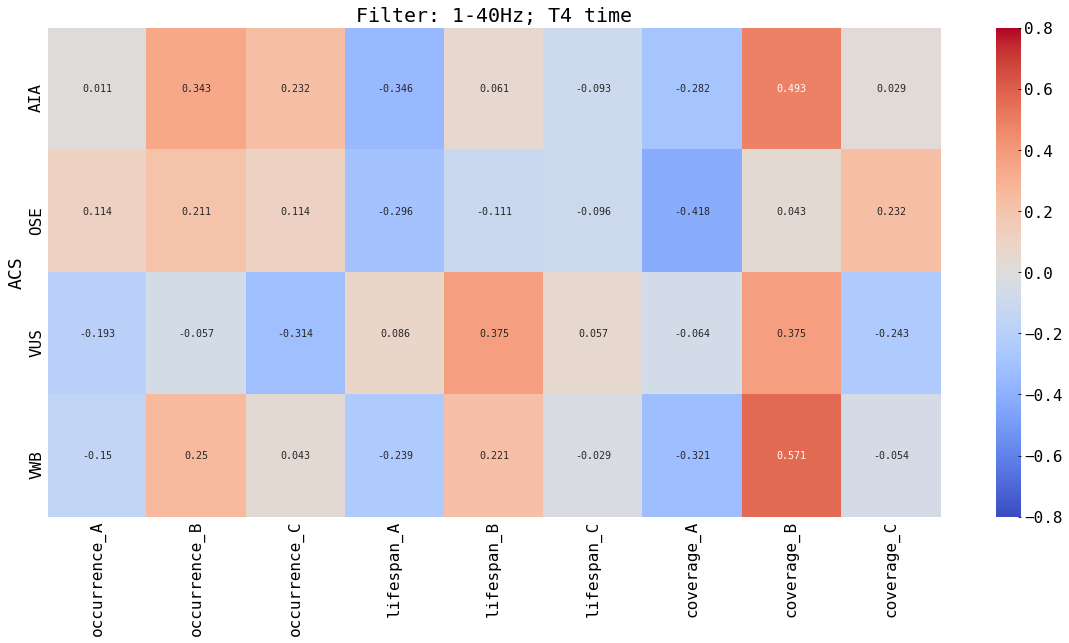

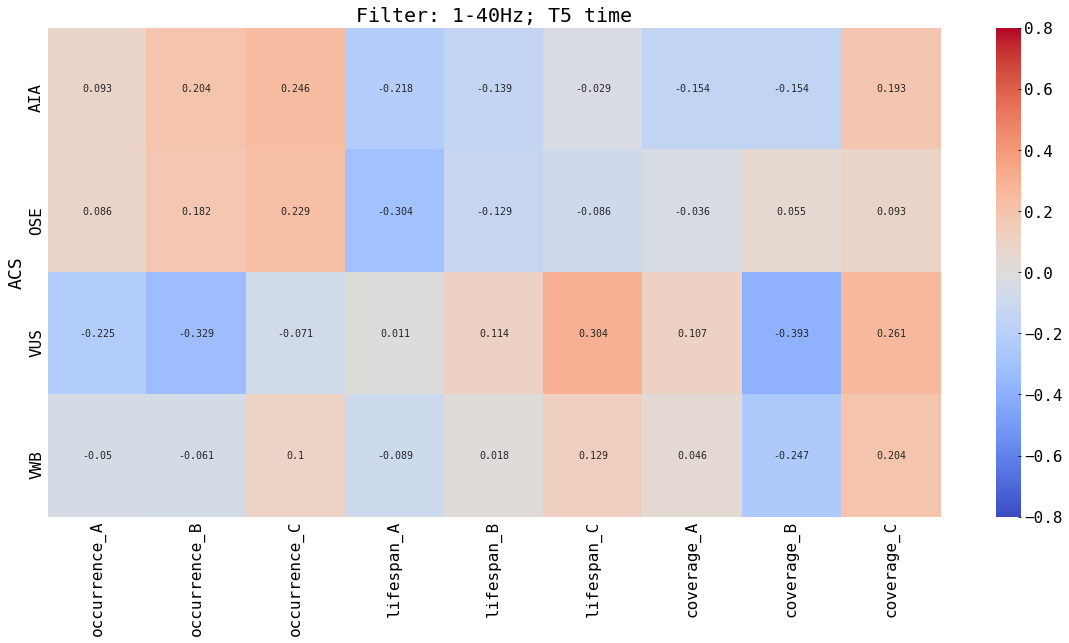

In [23]:
for time in np.unique(ms_stats_140["time"]):

    grand_r = pd.DataFrame()
    grand_annot = pd.DataFrame()

    for dv in ["occurrence", "lifespan", "coverage"]:
        df = ms_stats_140[ms_stats_140["condition"] == "PSI"][
            ["subject", "time", "microstate", dv]
        ]
        df = (
            df[df["time"] == time]
            .pivot(index="subject", columns="microstate", values=dv)
            .add_prefix(f"{dv}_")
        )
        df = pd.concat([experience_asc_conc.reset_index(), df.reset_index()], axis=1)
        columns = [
            ["AIA", "OSE", "VUS", "VWB"],
            [f"{dv}_A", f"{dv}_B", f"{dv}_C"],
        ]
        corrs = pg.pairwise_corr(
            df, columns, method="spearman", padjust=MULTI_CORRECTION, tail="one-sided"
        )
        r_vals = corrs.pivot(index="X", columns="Y", values="r")
        corr_stars = corrs.pivot(index="X", columns="Y", values="p-corr").round(3).applymap(lambda x: "".join(["*" for st in PVAL_STARS.keys() if x < st]))
        annot = r_vals.round(3).astype(str) + corr_stars
        grand_r = pd.concat([grand_r, r_vals], axis=1)
        grand_annot = pd.concat([grand_annot, annot], axis=1)
    plt.figure()
    sns.heatmap(grand_r, cmap="coolwarm", vmax=0.8, vmin=-0.8, annot=grand_annot, fmt="")
    plt.ylabel("ACS")
    plt.xlabel("")
    plt.title(f"Filter: 1-40Hz; {time} time")
    plt.show()